# Introduction

Model type : Sequence to Sequence models, encoder-decoder


Key architectures : Attention Mechanism

Appication : machine translation, speech recognition, text classification, and more


Previous method
* RNN
* LSTM

Problems with RNN
* Slow computation
* Vanishing or exploding gradients
* Hard to get infomation from long time ago

Problems with LSTM
* Less effective handling of long-range dependencies
* Too much parameters


# Transformer Overview

Notation

* VS : Vocab size
  * Depend on scenario
  * e.g. Chinese have about 3000 frequently used word, 3000 is vocab size
* $d_{model}$ : dimension of vector embedding
  * hyper parameter
  * set 128 here  
* T : Sequence's length
* h : number of head
* B : batch size
* $<bos>$ : Begin of Sentence
  * Might be different in different article
  * Special character that need to add in vocab space
* $<eos>$ : End of Sentence
  * Might be different in different article
  * Special character that need to add in vocab space
* $<pad>$ : padding
  * Fill the rest of the blank
  * Special character that need to add in vocab space
  

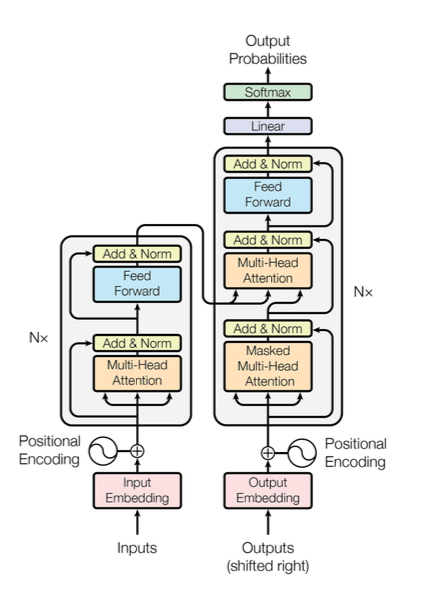

# Encoder

## Input Embedding

Suppose the vocab size is 3000, $d_{model}$ is 128.

$\mathop{Input}\limits_{(seq\ len,1)}$
$\mathop{=>}\limits_{embedding}$
$\mathop{after\ \ embedding}\limits_{(seq\ len, d_{model})}$
$\mathop{=>}\limits_{pos \ encoding }$
$\mathop{after\ \ encoding}\limits_{(seq\ len, d_{model})}$




A simple lookup table that stores embeddings of a fixed dictionary and size.

In [ ]:
import torch.nn as nn
import torch

embedding = nn.Embedding(num_embeddings = 20, embedding_dim = 128)
input = torch.LongTensor([1, 2, 18, 19]) # example of input

print(embedding.weight)
print("Before embedding shape : ",input.shape)
print("After  embedding shape : ",embedding(input).shape)

print(embedding(input)[:,:3])


Parameter containing:
tensor([[-0.0384,  0.9628, -0.9264,  ...,  0.6537,  2.3783,  2.0474],
        [ 0.6989, -1.2698,  0.7524,  ..., -1.5846,  0.4605,  0.3606],
        [ 0.1163,  1.0499, -1.1916,  ...,  0.3173,  2.2198, -0.5691],
        ...,
        [-0.5444,  0.3096,  1.7808,  ..., -0.7113, -0.8480, -0.3960],
        [ 1.8171, -1.1194, -1.6200,  ...,  2.0448,  0.0337,  1.4871],
        [-1.4987, -0.1414, -0.1533,  ..., -0.5384,  0.3860,  1.6145]],
       requires_grad=True)
Before embedding shape :  torch.Size([4])
After  embedding shape :  torch.Size([4, 128])
tensor([[ 0.6989, -1.2698,  0.7524],
        [ 0.1163,  1.0499, -1.1916],
        [ 1.8171, -1.1194, -1.6200],
        [-1.4987, -0.1414, -0.1533]], grad_fn=<SliceBackward0>)


## Positional Encoding

Text(0, 0.5, 'Length of the Sequence')

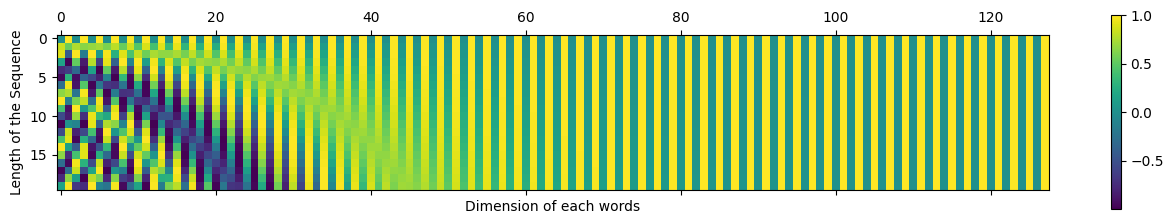

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def positionalEncoding(seq_length, d, n=10000):
    P = np.zeros((seq_length, d))
    for j in range(seq_length):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[j, 2*i] = np.sin(j/denominator)
            P[j, 2*i+1] = np.cos(j/denominator)
    return P
positional_encoding = positionalEncoding(20, 128)

cax = plt.matshow(positional_encoding)
plt.gcf().colorbar(cax)
plt.xlabel("Dimension of each words")
plt.ylabel("Length of the Sequence")

## Attention

### What is Attention?


* **Query**: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
* **Keys**: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is "offering", or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* **Values**: For each input element, we also have a value vector. This feature vector is the one we want to average over.


Visually, we can show the attention over a sequence of words as follows:

<center width="100%" style="padding:25px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/attention_example.svg?raw=1" width="750px"></center>

For every word, we have one key and one value vector. The query is compared to all keys with a score function (in this case the dot product) to determine the weights. The softmax is not visualized for simplicity. Finally, the value vectors of all words are averaged using the attention weights.


## Scaled Dot Product Attention



The core concept behind self-attention is the scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_{model}}$, keys $K\in\mathbb{R}^{T\times d_{model}}$ and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_{model}$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric. In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_{model}}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/scaled_dot_product_attn.svg?raw=1" width="210px"></center>

One aspect we haven't discussed yet is the scaling factor of $1/\sqrt{d_{model}}$. This scaling factor is crucial to maintain an appropriate variance of attention values after initialization. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma^2$ results in a scalar having $d_k$-times higher variance:

$$q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_{model}} q_i\cdot k_i\right) = \sigma^4\cdot d_{model}$$


If we do not scale down the variance back to $\sim\sigma^2$, the softmax over the logits will already saturate to $1$ for one random element and $0$ for all others. The gradients through the softmax will be close to zero so that we can't learn the parameters appropriately. Note that the extra factor of $\sigma^2$, i.e., having $\sigma^4$ instead of $\sigma^2$, is usually not an issue, since we keep the original variance $\sigma^2$ close to $1$ anyways.


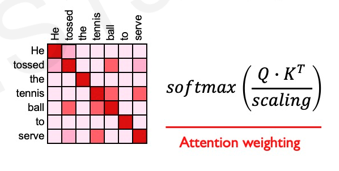

In [ ]:
import os
import numpy as np
import random
import math


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_model = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_model)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention
# Set value
seq_len, d_model = 8, 128

pl.seed_everything(42)
q = torch.randn(seq_len, d_model)
k = torch.randn(seq_len, d_model)
v = torch.randn(seq_len, d_model)
values, attention = scaled_dot_product(q, k, v)
print("Q",q.detach().shape,"\n", q)
print("K",k.detach().shape,"\n", k)
print("V",v.detach().shape,"\n", v)
print("Values\n", values)
print("Attention",attention.detach().shape,"\n", attention)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Q torch.Size([8, 128]) 
 tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.3399,  0.7200,  0.4114],
        [ 1.9312,  1.0119, -1.4364,  ...,  0.5655,  0.5058,  0.2225],
        [-0.6855,  0.5636, -1.5072,  ...,  0.8541, -0.4901, -0.3595],
        ...,
        [-1.2787, -0.0384,  1.9138,  ..., -1.6034, -0.4298,  0.5762],
        [ 0.3444, -3.1016, -1.4587,  ..., -0.3788, -1.5598, -0.8010],
        [-0.7111, -0.3867,  0.9578,  ...,  1.1085,  0.5544,  1.5818]])
K torch.Size([8, 128]) 
 tensor([[-1.2248,  0.9629, -1.5785,  ..., -0.6061,  0.6450, -0.2477],
        [-1.4078, -0.0801,  0.5194,  ..., -0.1173, -0.6305, -1.2655],
        [-0.2949, -0.2799,  1.0837,  ...,  1.2978,  0.3286,  0.1487],
        ...,
        [ 0.1070, -0.1015,  0.0830,  ...,  0.6982,  0.0521,  0.2882],
        [ 0.0595,  1.7286,  0.2921,  ...,  0.6600, -0.1619,  0.8861],
        [ 0.5484,  0.4577,  0.9677,  ..., -0.0334, -0.8276, -0.3524]])
V torch.Size([8, 128]) 
 tensor([[-0.6002, -0.0580,  0.2975,  ...,  1.1301, -0.333

## Mask Self-attention


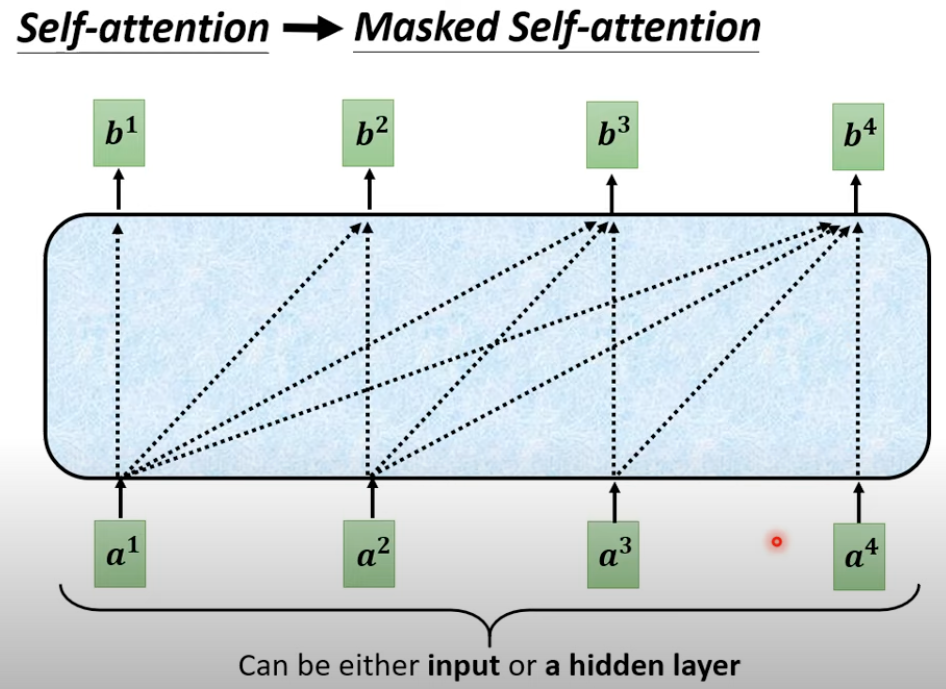

## Multi-Head Attention



The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_{model}}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_{model}}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and $W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/multihead_attention.svg?raw=1" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network, where we don't have an arbitrary query, key, and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

In [ ]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

## Resnet

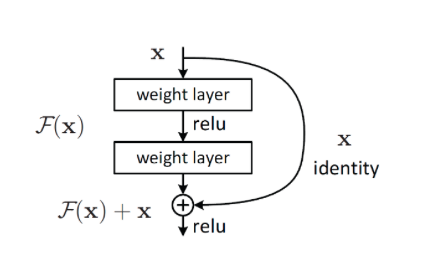

# Training

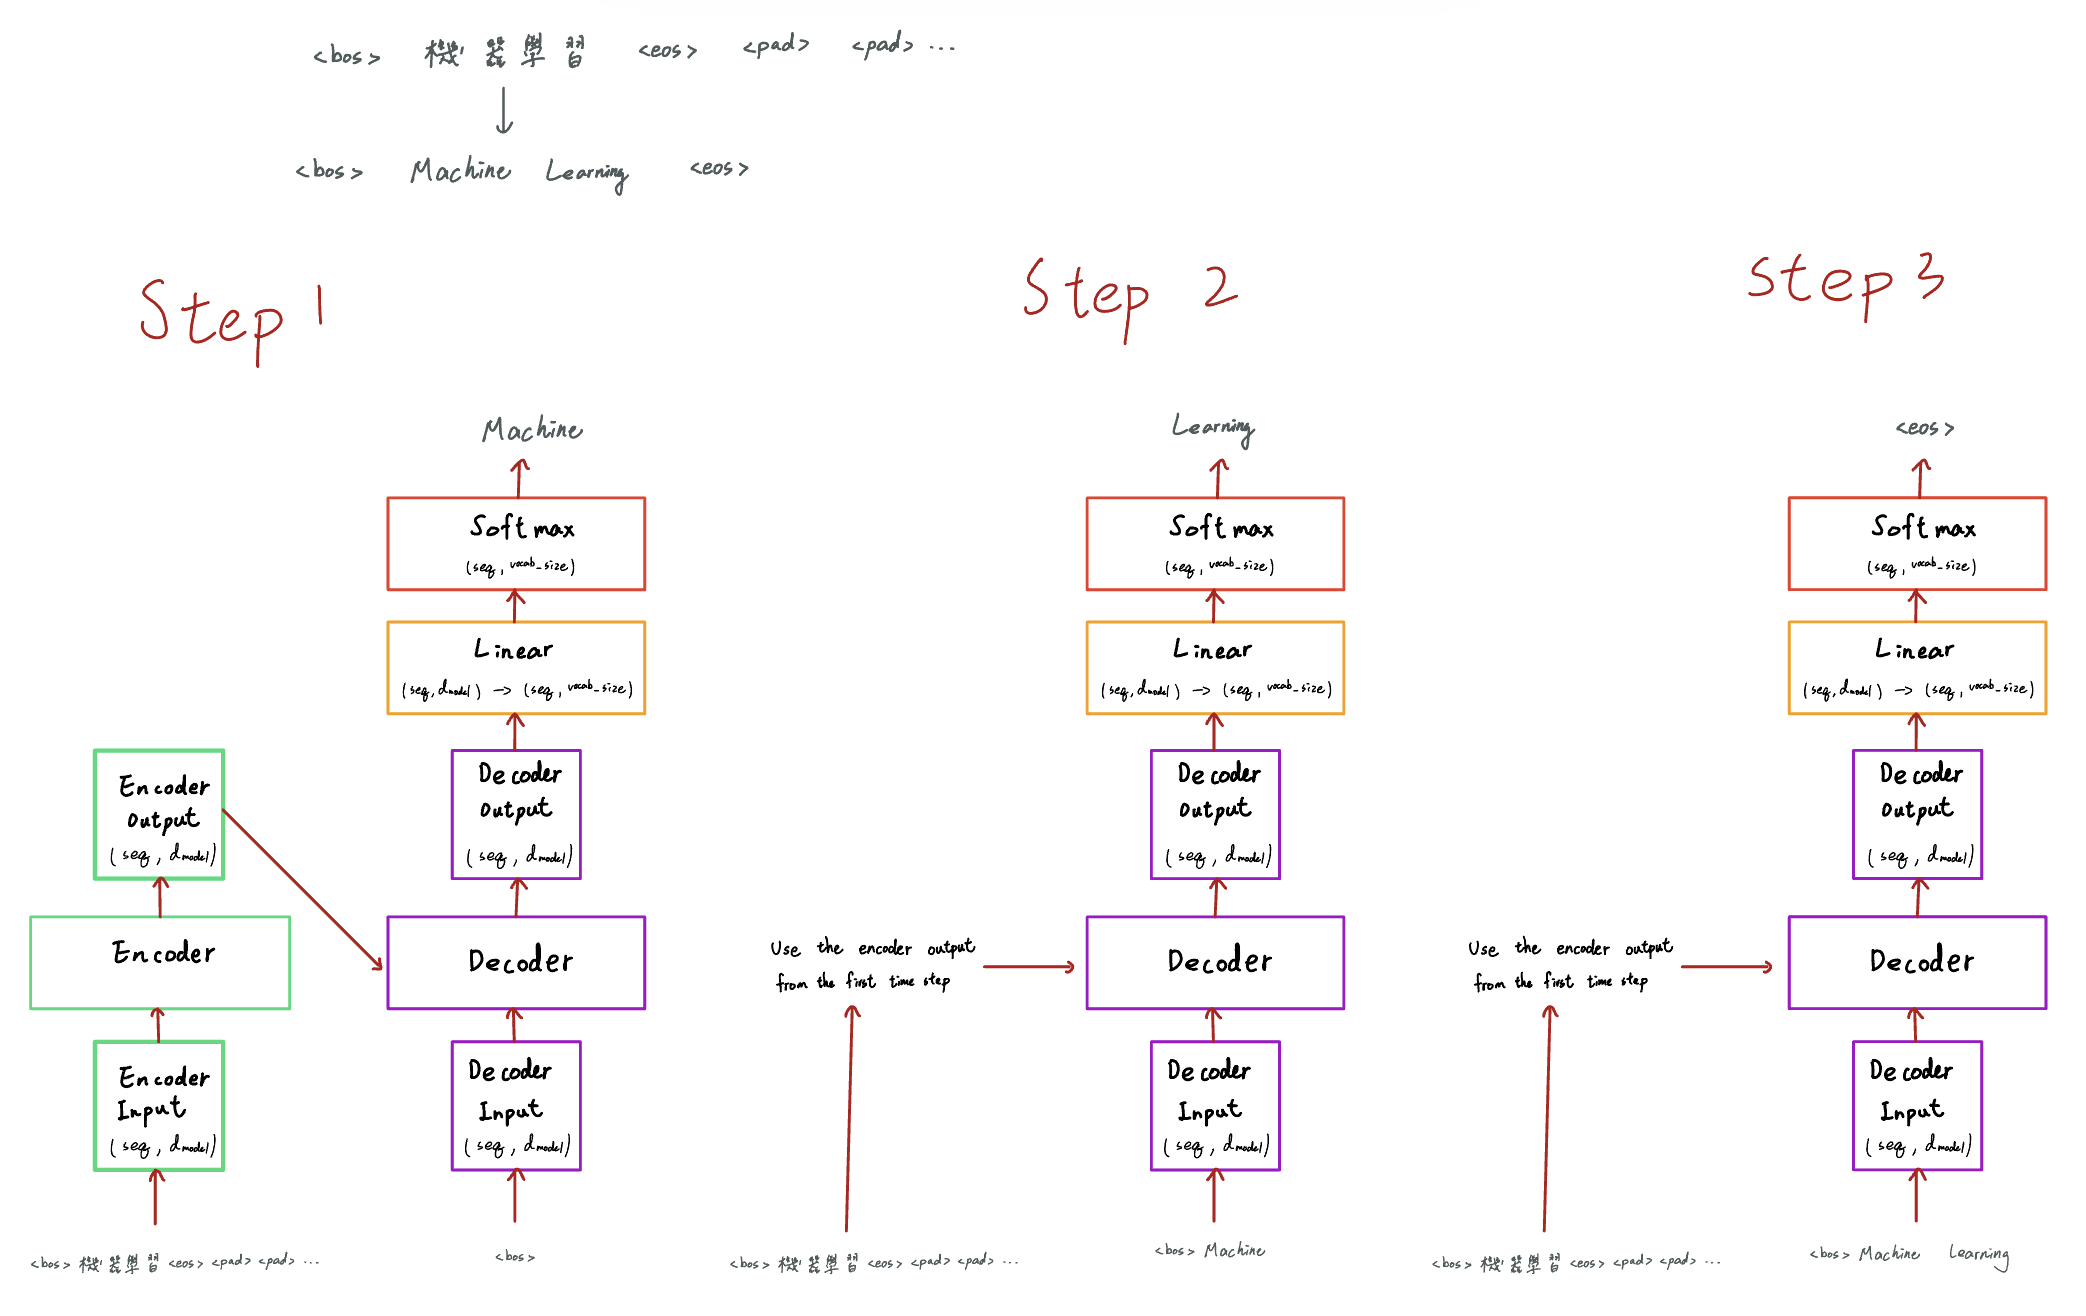

Concept in training : Teacher forcing
* Always show the machine right answer

In [ ]:
import math
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

max_length = 20

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout, max_len = 5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p = dropout)

    pe = torch.zeros(max_len, d_model)

    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
    )
    pe[:, 0::2] = torch.sin ( position * div_term)
    pe[:, 1::2] = torch.cos ( position * div_term)
    pe = pe.unsqueeze (0)
    self.register_buffer("pe", pe)
  def forward (self, x):
    x = x + self.pe[:, : x.size(1)].requires_grad_(False)
    return self.dropout (x)

class DoubleTaskModel(nn.Module):
  def __init__(self, d_model=128):
    super(DoubleTaskModel, self).__init__( )

    self.embedding = nn.Embedding(num_embeddings = 20, embedding_dim=128)

    self.transformer = nn.Transformer(d_model = 128,
                                        num_encoder_layers = 2,
                                        num_decoder_layers = 2,
                                        dim_feedforward = 512,
                                        batch_first = True)

    self.positional_encoding = PositionalEncoding(d_model, dropout=0)


    self.predictor = nn.Linear (128, 20)
  def forward( self, src, tgt):

    tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size()[-1])
    src_key_padding_mask = CopyTaskModel.get_key_padding_mask(src)
    tgt_key_padding_mask = CopyTaskModel.get_key_padding_mask(tgt)

    src = self.embedding(src)
    tgt = self.embedding(tgt)
    src = self.positional_encoding(src)
    tgt = self.positional_encoding(tgt)

    out = self.transformer(src,
                           tgt,
                           tgt_mask=tgt_mask,
                           src_key_padding_mask = src_key_padding_mask,
                           tgt_key_padding_mask = tgt_key_padding_mask)
    return out
  def get_key_padding_mask(tokens):
    key_padding_mask = torch.zeros(tokens.size ())
    key_padding_mask[tokens == 2] = -torch. inf
    return key_padding_mask

def generate_random_batch (batch_size, max_length=16):
  src = []
  for i in range (batch_size):
    # Generate sentences with random length
    random_len = random.randint (1, max_length - 2)

    random_nums = [0] + [random.randint (3, 9) for _ in range (random_len)] + [1]
    # Fill the rest of space with <pad>, we use 2 to represent it here.
    random_nums = random_nums + [2]* (max_length - random_len - 2)
    src.append (random_nums)
  src = torch.LongTensor(src)

  tgt =src[:,:-1]*2
  tgt_y = src[:, 1:]*2
  n_tokens = (tgt_y != 4).sum()
  return src, tgt, tgt_y, n_tokens

Train the model

In [ ]:
model = DoubleTaskModel()

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
total_loss = 0
history_loss = []


for step in range (1000):
  src, tgt, tgt_y, n_tokens = generate_random_batch (batch_size=10,max_length = 20)
  # 清空梯度
  optimizer.zero_grad()

  # 進行transformer的計算
  out = model(src, tgt)

  # 將結果送給最後的線性曾進行預測
  out = model.predictor (out)

  # 計算損失
  loss = criteria(out.contiguous().view(-1, out. size(-1)), tgt_y.contiguous().view(-1)) / n_tokens

  # 計算梯度
  loss.backward()

  # 更新參數
  optimizer.step()
  total_loss += loss

  history_loss.append(loss.item())
  # 每100次輸出一下loss
  if step != 0 and step % 100 == 0:
    print(f"Step = {step:4.0f} Loss = {loss:.7f}")
    total_loss = 0


Step =  100 Loss = 0.0085588
Step =  200 Loss = 0.0067632
Step =  300 Loss = 0.0048785
Step =  400 Loss = 0.0025291
Step =  500 Loss = 0.0026741
Step =  600 Loss = 0.0020524
Step =  700 Loss = 0.0015640
Step =  800 Loss = 0.0012313
Step =  900 Loss = 0.0010738


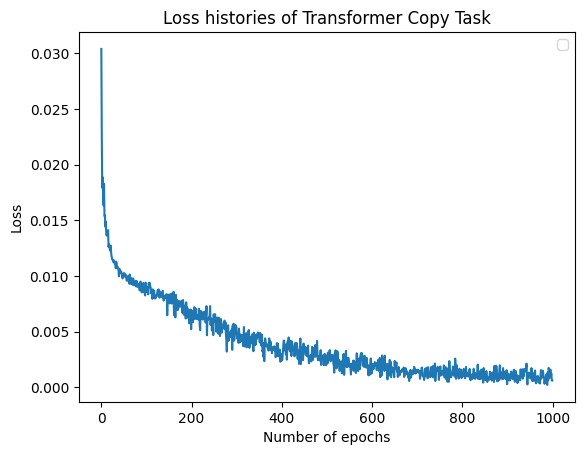

In [ ]:
plt.figure()
plt.plot(history_loss)


plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss histories of Transformer Copy Task")
plt.legend(loc = 'upper right')
plt.show()


In [ ]:
model = model.eval ()
# 隨意給一個 src
src = torch.LongTensor( [[0, 3, 7, 8, 9, 4, 6, 7, 1, 2, 2]])
# tgt從<bos>開始，看可不可以將所有src裡面的值乘2
tgt = torch.LongTensor ([[0]])

for i in range(max_length):
  # 進行transformer計算
  out = model(src, tgt)

  # 預測結果，因為每次只需要看最後一個詞，所以取out[:,-1]
  predict = model.predictor(out [:, -1])

  # 找出最大值的index
  y = torch.argmax( predict, dim = 1)

  # 和之前的預測結果連接在一起
  tgt = torch.concat( [tgt, y.unsqueeze(0)], dim=1)

  #如果是<eos>就結束
  if y == 2:
    break
print("Target : ",src)
print("Output : ",tgt)


Target :  tensor([[0, 3, 7, 8, 9, 4, 6, 7, 1, 2, 2]])
Output :  tensor([[ 0,  6, 14, 16, 18,  8, 12, 14,  2]])


# Reference
1. https://arxiv.org/abs/1706.03762
2. https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634
3. https://blog.csdn.net/zhaohongfei_358/article/details/122861751
4. https://blog.csdn.net/zhaohongfei_358/article/details/126019181
5. https://www.youtube.com/watch?v=bCz4OMemCcA
6. https://www.youtube.com/watch?v=ySEx_Bqxvvo
7. https://zhuanlan.zhihu.com/p/358206572
8. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
9. http://introtodeeplearning.com/
10. https://www.youtube.com/watch?v=N6aRv06iv2g




